In [6]:
import os
import sys
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal_array
%matplotlib inline
from math import isclose
import math
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

In [7]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [8]:
import numba
from numba import jit

In [9]:
dataset = gdal.Open('SUAV_42.dat')
rows = dataset.RasterYSize
cols = dataset.RasterXSize

num_bands = dataset.RasterCount
print('Image size is {r} rows x {c} columns\n'.format(r=rows, c=cols))
print('Number of bands in image: {n}\n'.format(n=num_bands))

Image size is 1098 rows x 2842 columns

Number of bands in image: 827



In [10]:
image_datatype = dataset.GetRasterBand(1).DataType

# Creamos una matriz de tipo cubo de forma eficiente

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount), dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
# Recorremos las bandas en el dataset mediante un bucle

for b in range(dataset.RasterCount):
    # El indice en GDAL empieza en 1 pero en python en 0 -- por lo que añadimos 1 para nuestras llamadas
    band = dataset.GetRasterBand(b + 1)
    # Leemos los datos en la tercera dimension (temporal) de nuestra matriz
    image[:, :, b] = band.ReadAsArray()

In [11]:
image = np.nan_to_num(image)
banda = np.arange(1,828,1)

In [12]:
def change_detection(arr):
     
    """     
    Funcion para detectar cambios en la serie temporal de NDVI. 
    Requiere de los paquetes: numpy y pandas
    Esta funcion fue programada por Miguel Moncada en octubre de 2019.
    """    

    # Transformamos el input array a serie para trabajar con pandas
    
    series = pd.Series(arr)
    window, scale = 46, 1.96
    
    # Computamos la media movil para el tamaño de ventana deseado y el n de desv. tipicas del intervalo de confianza
    
    rolling_mean = series.rolling(window=window).mean()
    
    # Calculamos el limite inferior del intervalo de confianza
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    
    rolling_mean = rolling_mean.fillna(0)
    
    # Creamos un array llamado 'lista' con la etiqueta del eje cuyo valor en 'y' es inferior al limite inferior 
    
    lista = banda[np.less(series,lower_bond)]
    
    # Creamos nuestros arrays vacios 'change' (donde incorporaremos anomalias - resultado final) y warn (incertidumbres)
    
    change = []
    warn = []
    
    # Filtramos las anomalías que no nos interesan comprobando si el cambio se ha mantenido en los valores adyacentes
    # Al comparar con los 3 siguientes valores, si nos encontramos con una anomalia al final de la serie tendremos warn
    
    for element in lista:
        
        if element >= 824:
            warn.append(999)
            
        else:
            a = arr[element-1]
            b = arr[element]
            c = arr[element+1]
            d = arr[element+2]
            
            if isclose(a,b,rel_tol=0.25) & isclose(a,c,rel_tol=0.3) & isclose(b,c,rel_tol=0.25)\
            & isclose(c,d,rel_tol=0.25):
                    change.append(element)
  
    change = np.array(change)
    
    # Comprobamos que haya más de un valor anómalo consecutivo en nuestro array y eliminamos los casos puntuales
    
    change = [i for i in change if np.isclose(np.delete(change,np.argwhere(change == i)),i,atol=5).any()]
            
    # Creamos un array con las anomalias en la media movil tomando un scale de 0.4
    
    window, scale = 46, 0.4
    
    second_rolling_mean = rolling_mean.rolling(window=window).mean()
    second_mae = mean_absolute_error(rolling_mean[window:], second_rolling_mean[window:])
    second_deviation = np.std(rolling_mean[window:] - second_rolling_mean[window:])
    second_lower_bond = second_rolling_mean - (second_mae + scale * second_deviation)
    
    vector = banda[np.less(rolling_mean,second_lower_bond)]
    
    if vector.size == 0:
        vector = np.append(vector,0)
    
    # Filtramos con los valores de anomalias en la media movil
    
    change = np.array([i for i in change if np.isclose(vector, i, atol=23).any()])
  
    # Redondeamos para obtener el año del cambio en cuestion
    
    change = 2001 + np.floor(change/46)
    
    # Obtenemos los valores unicos de nuestro array y devolvemos como salida el primero de estos
        
    change = np.unique(np.array(change)).astype(int)
    
    # Eliminamos años consecutivos en nuestro array 
    
    for i in range(1,change.size,1):
        if change[i] == change[i-1] + 1:
            change[i] = 0
        
    # Comprobamos que el array no esta vacio para evitar errores
    
    if change.size == 0:
        change = np.append(change,values = [0,0,0])
        
    elif change.size == 1:
        change = np.append(change,values = [0,0])

    elif change.size == 2:
        change = np.append(change,values = [0])
    
    
    return  change[0],change[1],change[2]

# INICIO PRUEBAS Y TEST DE LA VERSION 5

In [ ]:
def plotMovingAverage(series, window, scale, plot_intervals=False, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index) #, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    return rolling_mean, lower_bond

In [ ]:
pixel = []
numpix = []

a = -878
n = 1992
ba = 0

for band in image[a-1][n-1]:
    ba+=1
    
    pixel.append(band)
    numpix.append(ba)
    
    arr1 = np.array(numpix)
    arr2 = np.array(pixel)
    d = {'banda': arr1, 'valor': arr2, 'fila': a+1, 'columna': n+1}
    df3 = pd.DataFrame(d)

df3.iplot(kind='scatter', x='banda', y='valor')

In [ ]:
change_detection(arr2)

In [ ]:
media_movil, lower_bond = plotMovingAverage(pd.Series(arr2),46, scale=1.96, plot_intervals=True)
media_movil = np.nan_to_num(media_movil)

In [ ]:
mean, lower = plotMovingAverage(pd.Series(media_movil),46, scale=0.55,plot_intervals=True)

In [ ]:
mean, lower = plotMovingAverage(pd.Series(media_movil),46, scale=0.45,plot_intervals=True)

# FIN PRUEBAS Y TEST DE LA VERSION 5

In [13]:
array = np.apply_along_axis(change_detection,2,image)

In [14]:
array_first = array[:,:,0]
array_second = array[:,:,1]
array_third = array[:,:,2]

In [15]:
grid = np.indices((1098,2842))

df = pd.DataFrame()

df['Row'] = np.ravel(grid[0]+1)
df['Col'] = np.ravel(grid[1]+1)

df['Year1'] = np.ravel(array_first)
df['Year2'] = np.ravel(array_second)
df['Year3'] = np.ravel(array_third)

df.to_csv('OnlyCDV6_Y123_S42.csv')

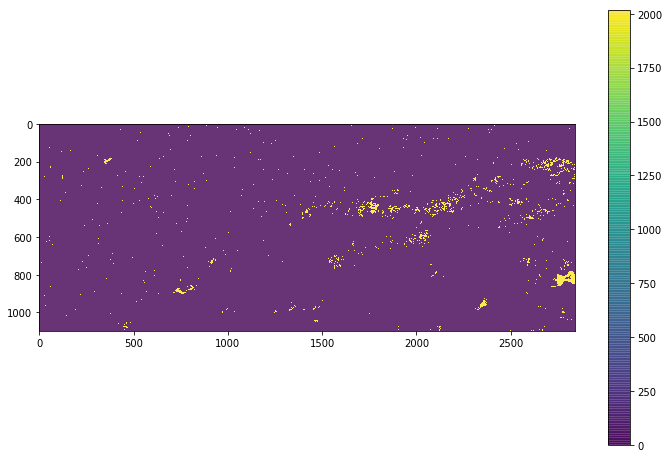

In [16]:
plt.figure(figsize=(12,8))
plt.imshow(array_first, cmap='viridis', alpha=0.8)
plt.colorbar()

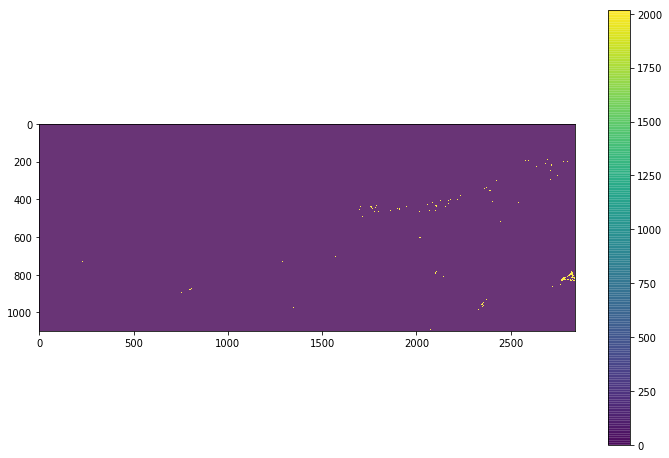

In [17]:
plt.figure(figsize=(12,8))
plt.imshow(array_second, cmap='viridis', alpha=0.8)
plt.colorbar()

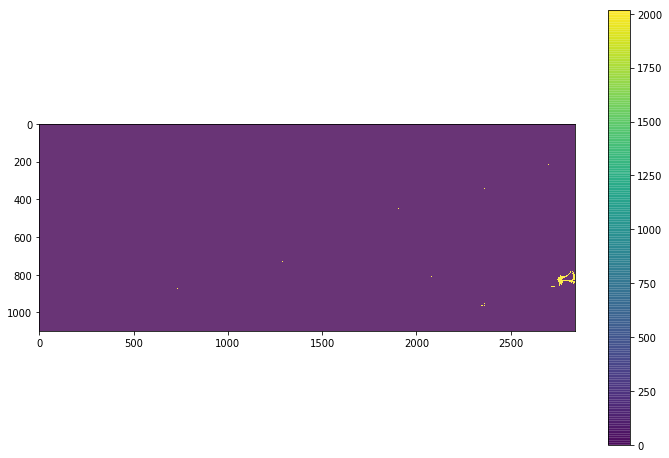

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(array_third, cmap='viridis', alpha=0.8)
plt.colorbar()

In [19]:
from gdalconst import *
from osgeo import osr

# Function to read the original file's projection:
def GetGeoInfo(FileName):
    SourceDS = gdal.Open(FileName, GA_ReadOnly)
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    DataType = SourceDS.GetRasterBand(1).DataType
    DataType = gdal.GetDataTypeName(DataType)
    driver = gdal.GetDriverByName('GTiff')
    return NDV, xsize, ysize, GeoT, Projection, DataType, driver

In [20]:
# Function to write a new file.
def CreateGeoTiff(Name, Array, driver, NDV, 
                  xsize, ysize, GeoT, Projection, DataType):
    if DataType == 'Float32':
        DataType = gdal.GDT_Float32
    NewFileName = Name+'.tif'
    # Set nans to the original No Data Value
    #Array[np.isnan(Array)] = NDV
    # Set up the dataset
    DataSet = driver.Create( NewFileName, xsize, ysize, 1, DataType)
            # the '1' is for band 1.
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection.ExportToWkt() )
    # Write the array
    DataSet.GetRasterBand(1).WriteArray( Array )
    #DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    return NewFileName

In [21]:
NDV, xsize, ysize, GeoT, Projection, DataType, driver = GetGeoInfo('SUAV_42.dat')

In [22]:
CreateGeoTiff('OnlyCDV6_SUAV42_first', array_first, driver, NDV, 
                  xsize, ysize, GeoT, Projection, DataType)

'OnlyCDV6_SUAV42_first.tif'

In [23]:
CreateGeoTiff('OnlyCDV6_SUAV42_second', array_second, driver, NDV, 
                  xsize, ysize, GeoT, Projection, DataType)

'OnlyCDV6_SUAV42_second.tif'

In [24]:
CreateGeoTiff('OnlyCDV6_SUAV42_third', array_third, driver, NDV, 
                  xsize, ysize, GeoT, Projection, DataType)

'OnlyCDV6_SUAV42_third.tif'